# Estimation and prediction in Gaussian random fields

Here we will study **Gaussian processes or random fiels**. We simulate spatial data, peform parameter estimation and predication (Kriging).

Consider a Matern covariance model for the spatial distinction of interest $x(s)$:

\begin{equation*}
Cov(x(s_i) , x(s_j)) = \sum_{ij} (|t_{ij}|) = \sigma^2 (1 + \eta |t_{ij}|) exp (- \eta |t_{ij}|), 
\end{equation*}
and data $ y(s_j) = x(s_j) + N( 0 , \tau^2) , j=1 , ... , m.$

Here $|t_{ij}|$ is the Euclidean distance between the two sites $s_i$ and $s_j$ , and the measurements $y_j = y(s_j)$ are assumed to be conditionally independent.

The unit square is the domain of interest. We assume a mean increasing with east and north coordinates as follows:
$\mu_i = \alpha((s_{i1} -0.5)+(s_{i2} -0.5))$, for site $s_i =(s_{i1},s_{i2} )$ on the unit
square.

## Exercise 1


In [2]:
# Import necessary library 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from random import sample
import pandas as pd
import random
from scipy.spatial import distance
from scipy import linalg

# Define constants and parameters 
m = 200 
sigma = 1 
eta = 10 
tau = 0.05 
alpha = 1 

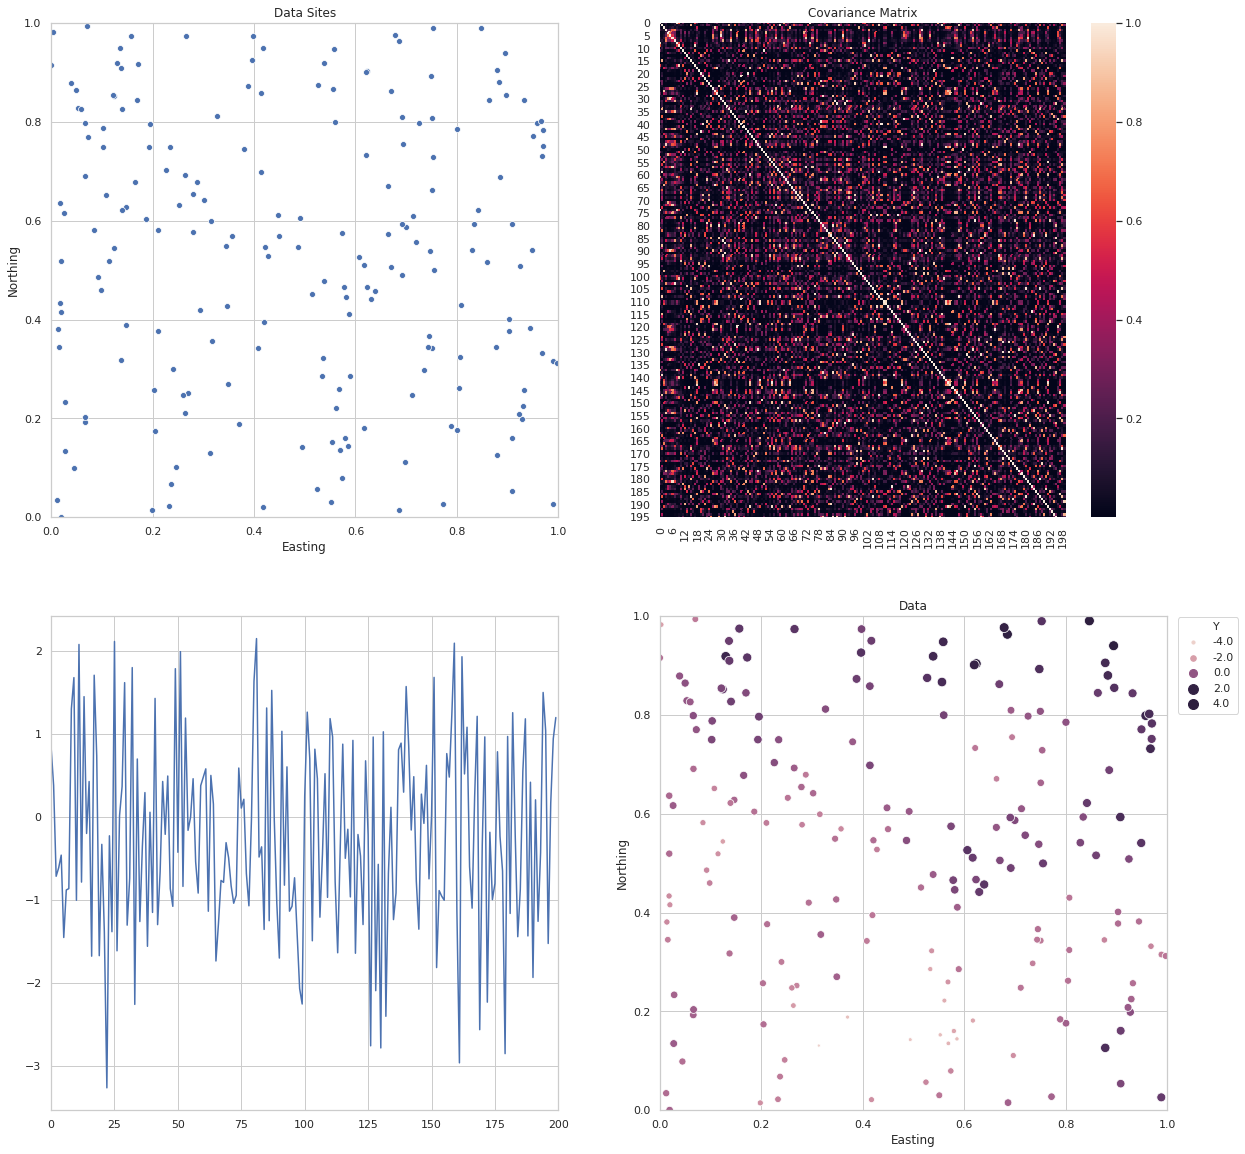

In [227]:
# Create model samples

def create_samples(m,sigma,eta,tau,alpha):
    x = np.zeros((m , 2))
    x[:,0] = np.random.uniform(0,1,m)
    x[:,1] = np.random.uniform(0,1,m)
    S = pd.DataFrame({'Easting' : x[:,0], 'Northing': x[:,1]} , columns=['Easting' , 'Northing'])
    spatial_cov = np.identity(m)*sigma
    for i in range(m-1):
        for j in range(i+1,m):
            tij = abs(distance.euclidean(x[i,:] , x[j,:]))
            spatial_cov[i , j] =  spatial_cov[j , i] = sigma * (1 + eta * tij) * np.exp(-(eta * tij))
    L = linalg.cholesky(spatial_cov) 
    U = np.random.normal(0, 1, m)
    tmp = np.transpose(L) @ U
    h = (x[:,0] + x[:,1] - 1)
    y = tmp + alpha*h + np.random.normal(0,np.sqrt(tau),m)
    S['Y'] = y
    return(x,y,h,S,spatial_cov)

np.random.seed(1)
x,y,h,S,spatial_cov = create_samples(m,sigma,eta,tau,alpha)

plt.figure(figsize=(20, 20))
ax = plt.subplot(221)
sns.set(style="whitegrid")
sns.scatterplot('Easting' , 'Northing' , data=S)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
plt.title('Data Sites')
plt.subplot(222)
sns.set(style="whitegrid")
sns.heatmap(spatial_cov)
plt.title('Covariance Matrix')
ax = plt.subplot(223)
ax.set_xlim(0,200)
plt.plot(y)
ax = plt.subplot(224)
sns.set(style="whitegrid")
sns.scatterplot(x="Easting", y="Northing", size="Y", hue = "Y",  sizes=(10, 100) , data=S)
ax.legend(loc='center left', bbox_to_anchor=(1.01, .90), ncol=1)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
plt.title('Data')
plt.show()

## Exercise 2


The data $\mathbf{y}$ now has the distribution
\begin{equation*}
\mathbf{y} \sim \mathcal{N}(\beta\mathbf{h},\mathbf{C}), \enspace \mathbf{C} = \mathbf{\Sigma} + \tau^2\mathbf{I},
\end{equation*}

where $\mathbf{\theta} = (\sigma^2, \eta, \tau^2)$ and $\mathbf{h}$ is the vector

\begin{equation*}
\mathbf{h} = \left[
\begin{array}{c}
  s_{11} + s_{12} - 1 \\
  s_{21} + s_{22} - 1 \\
  \vdots\\
  s_{n1} + s_{n2} - 1 \\
\end{array}
\right]
\end{equation*}

\begin{equation*}
l(\mathbf{y};\mathbf{\theta},\mathbf{\beta}) = \frac{n}{2}\log(2\pi) - \frac{1}{2}\log|\mathbf{C}| - \frac{1}{2}(\mathbf{y}- \mathbf{h}\beta)^T\mathbf{C}^{-1}(\mathbf{y} - \mathbf{h}\mathbf{\beta})
\end{equation*}

We want to find the maximum log-likelihood of the model parameters.

\begin{equation*}
(\hat{\mathbf{\beta}},\hat{\mathbf{\theta}}) = \underset{(\mathbf{\beta},\mathbf{\theta})}{\mathrm{argmax}}  l(\mathbf{y};\mathbf{\theta},\mathbf{\beta}).
\end{equation*}

For $\beta$ the maximum likelihood estimates becomes the least squares estimate with having $\theta$ fixed,  and you find this expression by derivating the above one with respect to $\beta$ and setting equal to zero.

\begin{equation*}
\hat{\mathbf{\beta}} = [\mathbf{h}^T\mathbf{C}^{-1}\mathbf{h}]^{-1}\mathbf{h}^T\mathbf{C}^{-1}\mathbf{y}.
\end{equation*}

For $\theta$ however we want to use the Newton-Rapshon algorithm. The derivatives is calculated while keeping $\beta$ constant, and $\mathbf{Q} = \mathbf{C}^{-1}$ and $\mathbf{Z} = \mathbf{Y} - \mathbf{h}\mathbf{\beta}$.

\begin{equation*}
\frac{dl}{d\theta_r} = -\frac{1}{2}\mathrm{trace}(\mathbf{Q}\frac{d\mathbf{C}}{d\theta_r}) + \frac{1}{2}Z^T\mathbf{Q}\frac{d\mathbf{C}}{d\theta_r}\mathbf{Q}\mathbf{Z}.
\end{equation*}

We also need to find the second derivative, but this can unbalanced because of the induced randomness to $\mathbf{y}$. Therefore it is better to use the expected value of the second derivative, which is given by the equation

\begin{equation*}
E(\frac{d^2l}{d\theta_sd\theta_r}) = -\frac{1}{2}\mathrm{trace}(\mathbf{Q}\frac{d\mathbf{C}}{d\theta_s}\mathbf{Q}\frac{d\mathbf{C}}{d\mathbf{\theta_r}}).
\end{equation*}

We need to find the derivative of the covariance matrix with respect to all the hyperparameters, which is 

\begin{equation*}
\frac{d\mathbf{C}}{d\sigma^2} =  (1 + \eta |t_{ij}|)\exp(-\eta|t_{ij}|), \enspace \frac{d\mathbf{C}}{d\eta} =  - \sigma^2\eta |t_{ij}|^2 \exp(-\eta|t_{ij}|), \enspace \frac{d\mathcal{C}}{d\tau^2} = \left\{ \begin{array}{c} 
1 , i = j \\ 
0 , i \neq j
\end{array} \right.
\end{equation*}

The partial derivates are calculated by the function below.

In [228]:

# calculate the partial derivatives of covariance matrix
def partial_derivative(theta, x,m): # theta = [sigma^2, eta, tau^2],
    tau_part = np.identity(m)
    sigma_part = np.identity(m)
    eta_part = np.zeros((m, m))
    for i in range(m-1):
        for j in range(i+1, m):
            tij = abs(distance.euclidean(x[i,:],x[j,:]))
            sigma_part[i, j] = sigma_part[j, i] = (1+theta[1]* tij)*np.exp(-theta[1]*tij)
            eta_part[i, j] =  eta_part[j, i] = -theta[0]*theta[1]*(tij**2)*np.exp(-theta[1]*tij)
    return(np.concatenate((sigma_part.reshape(m,m,1),eta_part.reshape(m,m,1),tau_part.reshape(m,m,1)),axis = 2))


# log-likelihood calculation
def calc_likelihood(C, Q, h, y, beta,m):
    return(m/2*np.log(2*np.pi)-1/2*np.log(np.linalg.det(C))-1/2*np.transpose(y-beta*h)@Q@(y-beta*h))  

def calc_C(theta,x,m):
    C = np.identity(m)*(theta[0]+theta[2])
    for i in range(m-1):
        for j in range(i+1, m):
            tij = abs(distance.euclidean(x[i,:], x[j,:]))
            C[i, j] = C[j, i] = theta[0]*(1+theta[1]*tij)*np.exp(-theta[1]*tij)
    Q = np.linalg.inv(C)
    return(C,Q)

# Fisher Scoring for optimization of log-likelihood
def make_score(Q, h, x, y, theta, beta,m):
    part_vec = partial_derivative(theta, x,m)
    likelihood_derivative = np.zeros(3)
    score_matrix = np.zeros((3, 3))
    for i in range(3):
        for j in range(3):
            score_matrix[i, j] = -(1/2)*np.trace((Q@part_vec[:,:,i]@Q)@part_vec[:,:,j])
        likelihood_derivative[i] = -(1/2)*np.trace(Q@part_vec[:,:,i])+(1/2)*np.transpose(y-beta*h)@(Q@part_vec[:,:,i]@Q)@(y-beta*h)
    
    return(np.linalg.inv(score_matrix)@likelihood_derivative)

def newton_raphson(x,h,y,m):
    theta = np.array([2, 5, 2])
    beta = 2
    count = 0
    while count < 20:
        C, Q = calc_C(theta,x,m)
        beta = 1/(np.transpose(h)@Q@h)*np.transpose(h)@Q@y
        theta = theta - make_score(Q, h, x, y, theta, beta,m)
        likelihood = calc_likelihood(C, Q, h, y, beta,m)
        print("beta = ",beta ,"; theta = ", theta, "; log-likelihood = ", likelihood,end="\r")
        count += 1
    return(beta, theta)

beta, theta = newton_raphson(x,h,y,m)


## Exercise 3
